# 1. Setup

In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

In [ ]:
# Horizontal Scrolling
import io
import base64
from IPython.display import HTML, display

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame, Series, Timedelta
from scipy.ndimage import binary_dilation
from sklearn.metrics import mean_absolute_error as MAE

In [ ]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from xgboost import XGBRegressor

In [ ]:
from utils.loading import load_all_raw_data
from utils.preprocessing import process_all_dfs
from utils.merging import merge_all_dfs
from utils.feature_engineering import *

In [ ]:
pd.set_option(
    "display.float_format",
    lambda x: f"{x:.2e}" if abs(x) < 0.01 and x != 0 else f"{x:.2f}",
)
pd.set_option('display.max_columns', 100)
pd.set_option("display.max_rows", 100)

In [ ]:
RAW_DATA_PATH = "../data/raw_data/"
ADDITIONAL_DATA_PATH = "../data/additional_data/"

SEGMENT_C = ["county", "product_type", "is_business"]
CATEGORICAL_C = ["county", "product_type", "is_business", "is_consumption"]
TARGET_C = [
    "county",
    "product_type",
    "is_business",
    "is_consumption",
    "datetime",
]
RAND = 10

# 2. Processing

In [ ]:
processed_dfs = process_all_dfs(
    load_all_raw_data(RAW_DATA_PATH, ADDITIONAL_DATA_PATH)
)

# processed_dfs.keys()
df = merge_all_dfs(processed_dfs, how="left")
df = add_dst_flag(df)
df = add_cyclic_datetime_features(df, drop_raw=True)

In [ ]:
for lag in [2, 3, 7]:
# for lag in range(2, 15):
    df = df.merge(
        get_lag(processed_dfs["train"][TARGET_C + ["target"]], lag=lag),
        how="left",
        on=TARGET_C,
    )

In [ ]:
for window in [24, 24 * 3, 24 * 7, 24 * 14]:
    # for window in [24 * i for i in range(1, 15)]:
    df = df.merge(
        get_moving_average(
            processed_dfs["train"]
            .set_index("datetime")
            .sort_index()
            .groupby(CATEGORICAL_C, observed=True, as_index=False),
            columns=["target"],
            window=window,
            # ).dropna(),
        ),
        how="left",
        on=TARGET_C,
    )

In [ ]:
df["t_over_cap"] = (df["2d_lag_target"] / df["installed_capacity"]).astype(
    "float32"
)
df["t_over_eic"] = (df["2d_lag_target"] / df["eic_count"]).astype("float32")
df["cap_per_eic"] = (df["installed_capacity"] / df["eic_count"]).astype(
    "float32"
)

# 3. Baselines comparison

In [ ]:
FEATURES_TO_DROP = ["datetime", "data_block_id", "date"]

## Train data

In [ ]:
print(
    f"First timestamp: {df["datetime"].min()}",
    f"Last timestamp: {df["datetime"].max()}",
    sep="\n"
)

First timestamp: 2021-09-01 00:00:00
Last timestamp: 2023-05-31 23:00:00


In [ ]:
# df["datetime"].is_monotonic_increasing
# df = df.sort_values('datetime', ignore_index=True)

In [ ]:
start_ts = df["datetime"].min()
splits_exp = [
    {
        "train": (
            start_ts,
            start_ts + pd.DateOffset(months=(12 + 3 * i)) - Timedelta(hours=1),
        ),
        "test": (
            start_ts + pd.DateOffset(months=(12 + 3 * i)),
            start_ts
            + pd.DateOffset(months=(12 + 3 * i + 1))
            - Timedelta(hours=1),
        ),
    }
    for i in range(3)
]
splits_exp

[{'train': (Timestamp('2021-09-01 00:00:00'),
   Timestamp('2022-08-31 23:00:00')),
  'test': (Timestamp('2022-09-01 00:00:00'),
   Timestamp('2022-09-30 23:00:00'))},
 {'train': (Timestamp('2021-09-01 00:00:00'),
   Timestamp('2022-11-30 23:00:00')),
  'test': (Timestamp('2022-12-01 00:00:00'),
   Timestamp('2022-12-31 23:00:00'))},
 {'train': (Timestamp('2021-09-01 00:00:00'),
   Timestamp('2023-02-28 23:00:00')),
  'test': (Timestamp('2023-03-01 00:00:00'),
   Timestamp('2023-03-31 23:00:00'))}]

In [ ]:
cat_cols = df.select_dtypes(include="category").columns.tolist()

(
    naive_mae,
    xgb_mae_history,
    lgbm_mae_history,
    cb_mae_history,
) = (
    [],
    [],
    [],
    [],
)

xgb_p = {
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 7,
    "random_state": RAND,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "reg:absoluteerror",
    "enable_categorical": True,
    "early_stopping_rounds": 20,
    "eval_metric": "mae",
    "n_jobs": -1,
}
lgbm_p = {
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 7,
    "random_state": RAND,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "regression_l1",
    "metric": "mae",
    "n_jobs": -1,
    "force_col_wise": True,
    "verbosity": -1,
}
cb_p = {
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 7,
    "random_state": RAND,
    "subsample": 0.8,
    "colsample_bylevel": 0.8,
    "loss_function": "MAE",
    "cat_features": cat_cols,
    "eval_metric": "MAE",
    "thread_count": -1,
    "verbose": False,
}

xgbr = XGBRegressor(**xgb_p)
lgbmr = LGBMRegressor(**lgbm_p)
cbr = CatBoostRegressor(**cb_p)

for split in splits_exp:
    df_train = df[
        (df["datetime"] >= split["train"][0])
        & (df["datetime"] <= split["train"][1])
    ].drop(FEATURES_TO_DROP, axis=1)
    df_val = df[
        (df["datetime"] >= split["test"][0])
        & (df["datetime"] <= split["test"][1])
    ].drop(FEATURES_TO_DROP, axis=1)

    X_train, y_train = (
        df_train.drop(["target"], axis=1),
        df_train["target"],
    )
    X_val, y_val = df_val.drop(["target"], axis=1), df_val["target"]
    # X_test, y_test = df_test.drop(["target"], axis=1), df_test["target"]

    eval_set = [
        (X_train, y_train),
        (X_val, y_val),
        # (X_test, y_test)
    ]
    # print(f"{i+1} split")

    # Naive baseline
    naive_mae.append(
        {
            "validation_0": MAE(
                eval_set[0][1].loc[X_train["2d_lag_target"].notna()],
                eval_set[0][0]["2d_lag_target"].loc[
                    X_train["2d_lag_target"].notna()
                ],
            ),
            "validation_1": MAE(
                eval_set[1][1].loc[X_val["2d_lag_target"].notna()],
                eval_set[1][0]["2d_lag_target"].loc[
                    X_val["2d_lag_target"].notna()
                ],
            ),
        }
    )

    for model in [
        xgbr,
        lgbmr,
        cbr,
    ]:

        if isinstance(model, XGBRegressor):
            # print("XGBRegressor")
            model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                verbose=0,
                # verbose=25,
            )
            xgb_mae_history.append(model.evals_result())

        elif isinstance(model, LGBMRegressor):
            # print("LGBMRegressor")
            model.fit(
                X_train,
                y_train,
                categorical_feature=cat_cols,
                eval_set=eval_set,
                callbacks=[
                    early_stopping(
                        stopping_rounds=20,
                        verbose=0,
                    ),
                    # log_evaluation(period=25),
                ],
            )
            lgbm_mae_history.append(model.evals_result_)

        elif isinstance(model, CatBoostRegressor):
            # print("CatBoostRegressor")
            model.fit(
                X_train, y_train, eval_set=eval_set, early_stopping_rounds=20
            )
            cb_mae_history.append(model.evals_result_)

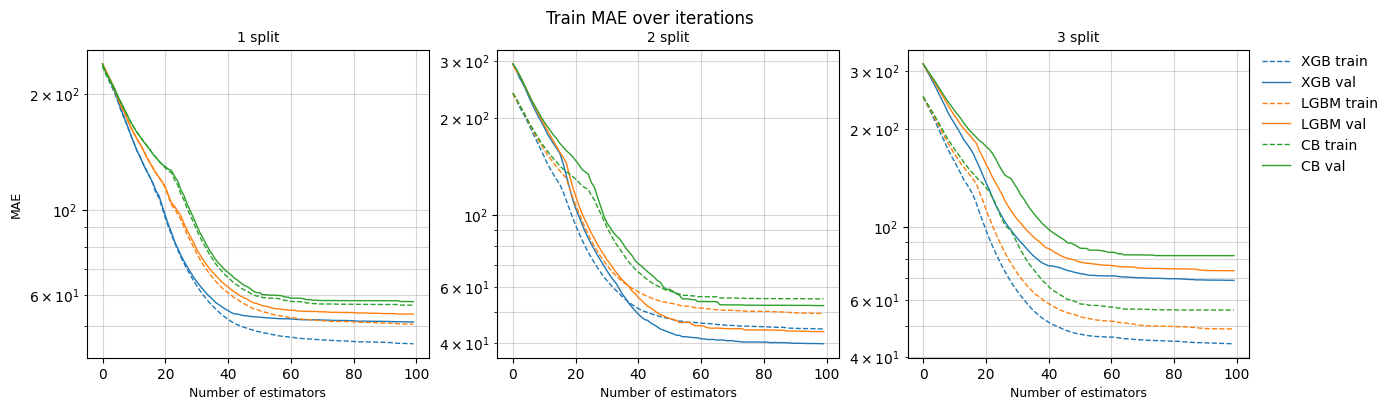

In [ ]:
total_splits = len(splits_exp)
rows, cols = 1, 3
fig, axs = plt.subplots(rows, cols, figsize=(15, 4))

axs = axs.flatten()

for split_i in range(total_splits):
    ax = axs[split_i]
    ax.plot(
        xgb_mae_history[split_i]["validation_0"]["mae"],
        "C0--",
        label=f"XGB train",
        lw=1,
    )
    ax.plot(
        xgb_mae_history[split_i]["validation_1"]["mae"],
        "C0",
        label=f"XGB val",
        lw=1,
    )
    ax.plot(
        lgbm_mae_history[split_i]["training"]["l1"],
        "C1--",
        label=f"LGBM train",
        lw=1,
    )
    ax.plot(
        lgbm_mae_history[split_i]["valid_1"]["l1"],
        "C1",
        label=f"LGBM val",
        lw=1,
    )
    ax.plot(
        cb_mae_history[split_i]["validation_0"]["MAE"],
        "C2--",
        label=f"CB train",
        lw=1,
    )
    ax.plot(
        cb_mae_history[split_i]["validation_1"]["MAE"],
        "C2",
        label=f"CB val",
        lw=1,
    )

    if split_i >= total_splits - cols:
        ax.set_xlabel("Number of estimators", size=9)
    if split_i in [i * cols for i in range(rows)]:
        ax.set_ylabel("MAE", size=9)
    ax.set_title(f"{split_i + 1} split", size=10)
    ax.grid(which="both", alpha=0.5)
    ax.set_yscale("log")
plt.legend(
    loc="upper left",
    bbox_to_anchor=(1, 1.025),
    frameon=False,
)
fig.suptitle(
    "Train MAE over iterations",
    # y=1.0125,
    fontsize=12,
)
# plt.tight_layout()

plt.show()

In [ ]:
model_names = ["XGBoost", "LightGBM", "CatBoost", "Naive"]
mae_results = []

for i in range(total_splits):
    mae_results.append(
        {
            "model": "XGBoost",
            "dataset": "train",
            "mae": xgb_mae_history[i]["validation_0"]["mae"][-1],
        }
    )
    mae_results.append(
        {
            "model": "XGBoost",
            "dataset": "val",
            "mae": xgb_mae_history[i]["validation_1"]["mae"][-1],
        }
    )
    mae_results.append(
        {
            "model": "LightGBM",
            "dataset": "train",
            "mae": lgbm_mae_history[i]["training"]["l1"][-1],
        }
    )
    mae_results.append(
        {
            "model": "LightGBM",
            "dataset": "val",
            "mae": lgbm_mae_history[i]["valid_1"]["l1"][-1],
        }
    )
    mae_results.append(
        {
            "model": "CatBoost",
            "dataset": "train",
            "mae": cb_mae_history[i]["validation_0"]["MAE"][-1],
        }
    )
    mae_results.append(
        {
            "model": "CatBoost",
            "dataset": "val",
            "mae": cb_mae_history[i]["validation_1"]["MAE"][-1],
        }
    )
    mae_results.append(
        {
            "model": "Naive",
            "dataset": "train",
            "mae": naive_mae[i]["validation_0"],
        }
    )
    mae_results.append(
        {
            "model": "Naive",
            "dataset": "val",
            "mae": naive_mae[i]["validation_1"],
        }
    )

df_mae = pd.DataFrame(mae_results)
df_mae

,model,dataset,mae
0,XGBoost,train,44.92
1,XGBoost,val,51.17
2,LightGBM,train,50.50
3,LightGBM,val,53.59
4,CatBoost,train,56.47
5,CatBoost,val,57.73
6,Naive,train,78.13
7,Naive,val,88.57
8,XGBoost,train,44.34
9,XGBoost,val,39.90


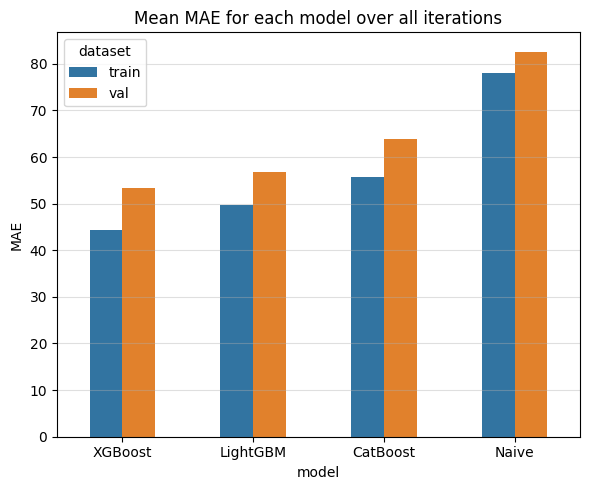

In [ ]:
plt.figure(figsize=(6, 5))
sns.barplot(
    data=df_mae,
    x="model",
    y="mae",
    hue="dataset",
    errorbar=None,
    dodge=True,
    width=0.5,
)
plt.title("Mean MAE for each model over all iterations")
plt.ylabel("MAE")
plt.grid(True, axis="y", alpha=0.4)
plt.tight_layout()
plt.show()

The XGBoost baseline shows the best results while the LightGBM baseline performs slightly worse. The gap with the CatBoost baseline is more significant, and XGBoost clearly outperforms the naive baseline.

## Test data

In [ ]:
# start_ts = df["datetime"].min()
test_splits = [
    {
        "train": (
            start_ts,
            start_ts + pd.DateOffset(months=19) - Timedelta(hours=1),
        ),
        "test": (
            start_ts + pd.DateOffset(months=19),
            start_ts + pd.DateOffset(months=20) - Timedelta(hours=1),
        ),
    },
    {
        "train": (
            start_ts,
            start_ts + pd.DateOffset(months=20) - Timedelta(hours=1),
        ),
        "test": (
            start_ts + pd.DateOffset(months=20),
            start_ts + pd.DateOffset(months=21) - Timedelta(hours=1),
        ),
    },
]
test_splits

[{'train': (Timestamp('2021-09-01 00:00:00'),
   Timestamp('2023-03-31 23:00:00')),
  'test': (Timestamp('2023-04-01 00:00:00'),
   Timestamp('2023-04-30 23:00:00'))},
 {'train': (Timestamp('2021-09-01 00:00:00'),
   Timestamp('2023-04-30 23:00:00')),
  'test': (Timestamp('2023-05-01 00:00:00'),
   Timestamp('2023-05-31 23:00:00'))}]

In [ ]:
test_scores = []
xgb_p["early_stopping_rounds"] = None

xgbr = XGBRegressor(**xgb_p)
lgbmr = LGBMRegressor(**lgbm_p)
cbr = CatBoostRegressor(**cb_p)

for split in test_splits:
    df_train = df[
        (df["datetime"] >= split["train"][0])
        & (df["datetime"] <= split["train"][1])
    ].drop(FEATURES_TO_DROP, axis=1)

    X_train, y_train = (
        df_train.drop(["target"], axis=1),
        df_train["target"],
    )

    df_test = df[
        (df["datetime"] >= split["test"][0])
        & (df["datetime"] <= split["test"][1])
    ].drop(FEATURES_TO_DROP, axis=1)

    X_test, y_test = (
        df_test.drop(["target"], axis=1),
        df_test["target"],
    )

    # Naive baseline
    test_scores.append(
        MAE(
            y_test.loc[X_test["2d_lag_target"].notna()],
            X_test["2d_lag_target"].dropna(),
        ),
    )

    for model in [
        xgbr,
        lgbmr,
        cbr,
    ]:

        if isinstance(model, XGBRegressor):
            model.fit(
                X_train,
                y_train,
                verbose=0,
            )

        elif isinstance(model, LGBMRegressor):
            model.fit(
                X_train,
                y_train,
                categorical_feature=cat_cols,
            )

        elif isinstance(model, CatBoostRegressor):
            model.fit(
                X_train,
                y_train,
            )

        test_scores.append(MAE(y_test, model.predict(X_test)))

In [ ]:
test_mae = DataFrame(
    {
        "model": [
            "Naive",
            "XGBoost",
            "LightGBM",
            "CatBoost",
        ]
        * 2,
        "mae": test_scores,
        "dataset": ["april_test"] * 4 + ["may_test"] * 4,
    }
)
test_mae

,model,mae,dataset
0,Naive,127.00,april_test
1,XGBoost,84.81,april_test
2,LightGBM,90.45,april_test
3,CatBoost,93.70,april_test
4,Naive,122.23,may_test
5,XGBoost,90.65,may_test
6,LightGBM,95.52,may_test
7,CatBoost,102.26,may_test


In [ ]:
df_mae = pd.concat([df_mae, test_mae])

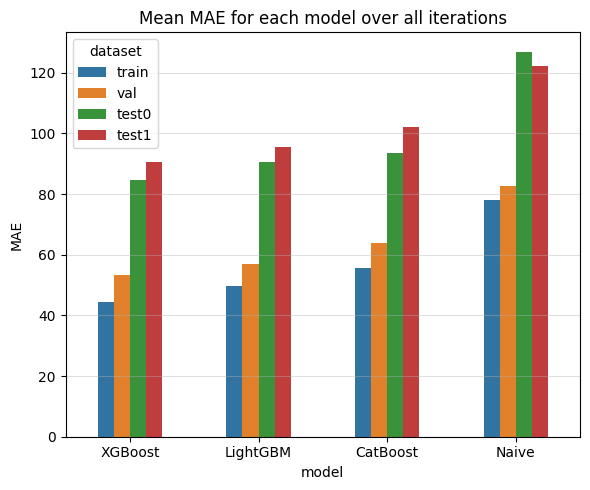

In [ ]:
plt.figure(figsize=(6, 5))
sns.barplot(
    data=df_mae,
    x="model",
    y="mae",
    hue="dataset",
    errorbar=None,
    dodge=True,
    width=0.5,
)
plt.title("Mean MAE for each model over all iterations")
plt.ylabel("MAE")
plt.grid(True, axis="y", alpha=0.4)
plt.tight_layout()
plt.show()

In [ ]:
np.mean(test_scores[1::4])

np.float64(87.72918701171875)

On the test data for both months, XGBoost also shows the best results, with MAE values of 84.81 and 90.65.